In [209]:
from matplotlib import pyplot as plt
import numpy as np
from pfb_fixed import FixPFB as pfbx
from pfb_floating import FloatPFB as pfbl
from fixpoint import fixpoint, cfixpoint

This document studies the differences in the result depending on the rounding scheme adopted. For this study, I will first take an input signal of some noise with 3 tones, then a signal with a positive and negative spike. The first signal will require aggressive shifting, whilst the second will require no shifting.

The standard PFB implementation used will be based on that of the SARAO 4k F-Engine. The FIR filters will be 8tap, use hamming filtering, have 10bit input, 18bit output, and 18bit coefficients. The FFT will use $\textit{saturate}$ overflow (although SARAO uses a $\textit{wrap}$ overflow), 18bit coefficients, 18bit input data and 18bit output data. The rounding schemes to test are that of truncation, unbaised round $\pm\infty$ and even rounding (bankers rounding).  

In [211]:
#Plotting scheme function
def tworesplotter(res1,res2):
    fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(12, 12))
    ax[0,0].plot(res1,'k')
    ax[0,0].set_title("Fixed point result\n for three tone signal",fontsize=16)
    ax[0,1].plot(res2,'k')
    ax[0,1].set_title("Floating point result\n for three tone signal",fontsize=16)
    ax[1,0].plot(res1,'k')
    ax[1,0].set_ylim(-10,25)
    ax[1,0].set_xlim(-10,300)
    ax[1,1].plot(res2,'k')
    ax[1,1].set_ylim(-10,25)
    ax[1,1].set_xlim(-10,300)
    ax[0,2].plot(np.abs(res1-res2),'k')
    ax[0,2].set_title("Difference between results\nfor three tone signal",fontsize=16)
    ax[1,2].plot(np.abs(res1-res2),'k')
    ax[1,2].set_xlim(-10,300)
    ax[1,2].set_ylim(-10,25)
    fig.text(0.5, 0.04, 'channels', ha='center',fontsize=16)
    fig.text(0.04, 0.5, '$<S_{xx}>$', va='center', rotation='vertical',fontsize=16)
    fig.show()


SNR =  31.51150667959522
dBFS =  -28.33495660842711


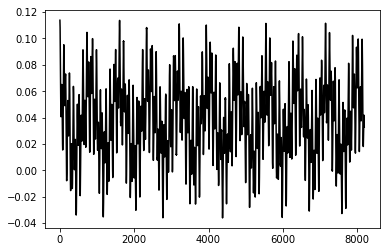

In [213]:
N=(2**13)*8                                                   #DATA LENGTH = 8 x 8K
noise = ((np.random.normal(size=N,scale = 0.3)+0.5).astype(np.float64)/620)  #NOISE SIGNAL
tone1=((np.cos(82*2*np.pi*np.arange(N)/(N)).astype(np.float64)+0.5)/40)  #TONES
tone2=((np.cos(532*2*np.pi*np.arange(N)/(N)).astype(np.float64)+0.5)/40)  
tone3=((np.cos(1265*2*np.pi*np.arange(N)/(N)).astype(np.float64)+0.5)/40)
tones = tone1+tone2+tone3
input_vector = noise+tones                       #FINAL INPUT VECTOR
plt.plot(input_vector[:2**13],'k')
print("SNR = ", 20*np.log10(np.max(np.abs(tones[:2**15]))/np.max(np.abs(noise[:2**15]))))
print("dBFS = ", 20*np.log10(np.mean(input_vector[:2**15])/(1)))
input_vector-=np.mean(input_vector)              #REMOVE DC

First we test the operation of a $\textit{truncation}$ rounding method. As previously stated, we will aggressively shift for this test i.e. all ones.

In [214]:
inpfxsig=cfixpoint(9,9,method="TRUNCATE")     #FIXED POINT INPUT DATA TYPE - 9bits with sign bit = 10
inpfxsig.from_complex(input_vector)           #LOAD IN ABOVE SIGNAL
shiftreg=[1,1,1,1,1,1,1,1,1,1,1,1,1]          #SHIFTREGISTER
pfbfxdt = pfbx(N=2**13,taps=8,bits_in=9,bits_out=17,twidbits=17,shiftreg=shiftreg.copy(),
               w='hamming',firmethod="TRUNCATE",fftmethod="TRUNCATE")    #BUILD 8k FIXED PT PFB
pfbflt = pfbl(N=2**13,taps=8,w='hamming')     #BUILD 8K FLOAT PT PFB
pfbfxdt.run(inpfxsig)                         #RUN FIX PFB ON INPUT DATA
pfbflt.run(input_vector)                      #RUN FLOAT PFB ON INPUT DATA

In order to reverse the effects of the shift register and fir register, we multiply by $2^{\textrm{#1's in shifteg}}\times2^{\textrm{bits accumulated through fir sum}}$ which in our case $=2^{17}$.
Below we display the results for the truncated fixed point PFB alongside the floating point instance. The row below that is a 'zoomed' plot. Finally, the two errors stated at the top are the mean absolute difference over the zoomed and full result. Finally, in the plot, we are using the last of the eight outputs from the PFB (i.e. ensuring the FIR registers are fully populated by this time).

MEAN DIFFERENCE OVERALL =  0.6807166805465876
ZOOMED MEAN DIFFERENCE =  1.2226569488016352


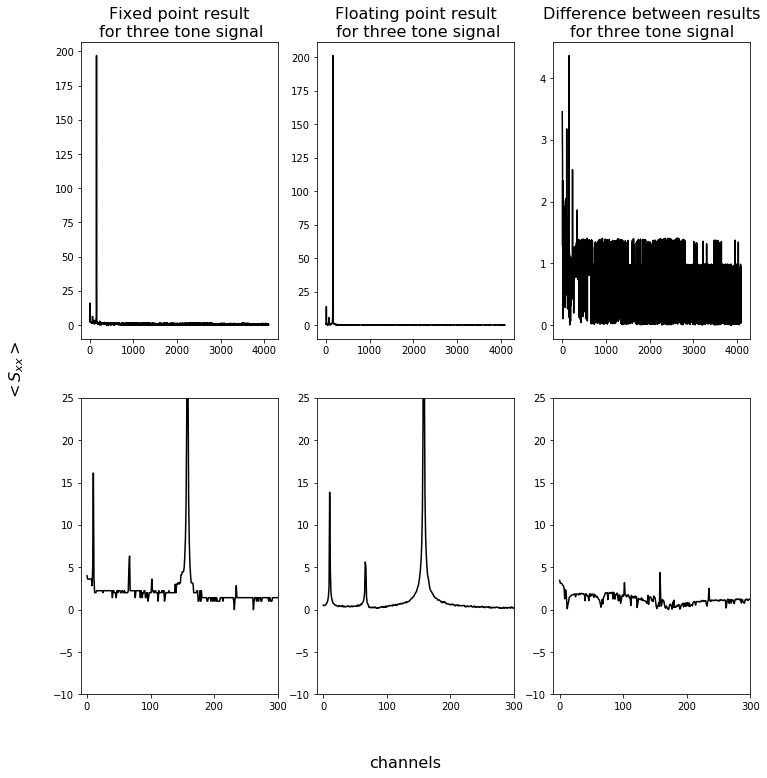

In [216]:
tworesplotter(np.abs(pfbfxdt.X_k.to_complex()[:2**12,-1]*2**17),np.abs(pfbflt.X_k)[:2**12,-1])
meandifftrunc=np.mean(np.abs(np.abs(pfbfxdt.X_k.to_complex()[:2**12,-1]*2**17)-np.abs(pfbflt.X_k)[:2**12,-1]))
meandifftrunczoom=np.mean(np.abs(np.abs(pfbfxdt.X_k.to_complex()[:300,-1]*2**17)-np.abs(pfbflt.X_k)[:300,-1]))
print("MEAN DIFFERENCE OVERALL = ",meandifftrunc)
print("ZOOMED MEAN DIFFERENCE = ",meandifftrunczoom)

In both instances, we have detected the primary 3 tones in the signal. Aggressive shifting has largely flattened the noise except for some odd spikes. 

Below we test the fixed point PFB with the $\pm\infty$ rounding (Round up if positive or round down if negative) scheme. 

In [217]:
inpfxsig=cfixpoint(9,9,method="ROUND_INFTY")           #MAKE INPUT DATA USE INFTY ROUNDING
inpfxsig.from_complex(input_vector)
pfbfxdru = pfbx(N=2**13,taps=8,bits_in=9,bits_out=17,twidbits=17,shiftreg=shiftreg.copy(),
                w='hamming',firmethod="ROUND_INFTY",fftmethod="ROUND_INFTY") #BUILD FIXPT PFB
pfbfxdru.run(inpfxsig)                                 #RUN PFB ON DATA

And plot the results and the differences

MEAN DIFFERENCE OVERALL =  1.04952196451003
ZOOMED MEAN DIFFERENCE =  1.6286465903700758


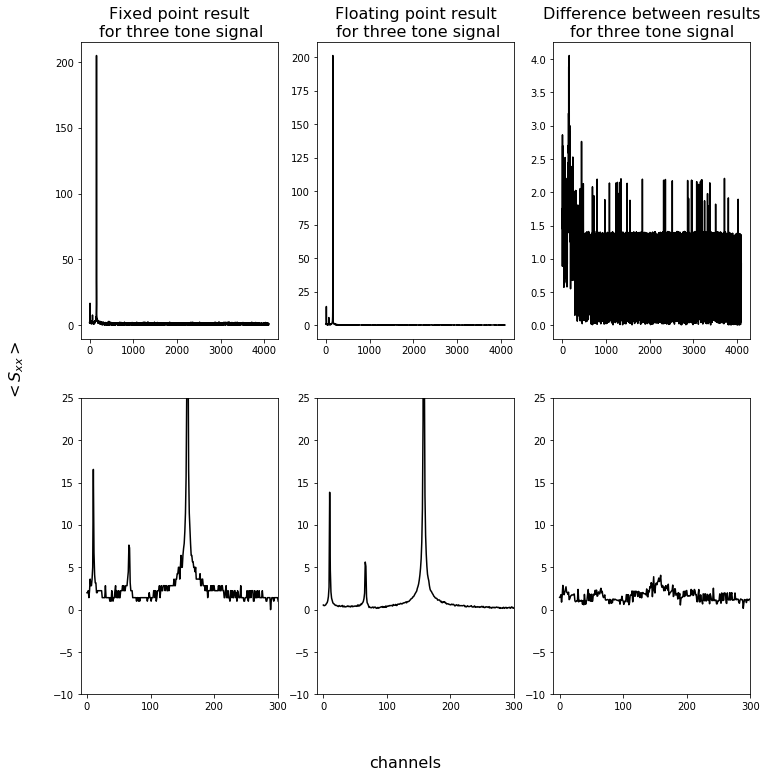

In [218]:
meandiffinfinite=np.mean(np.abs(np.abs(pfbfxdru.X_k.to_complex()[:2**12,-1]*2**17)-np.abs(pfbflt.X_k)[:2**12,-1]))
meandiffinfinitezoom=np.mean(np.abs(np.abs(pfbfxdru.X_k.to_complex()[:300,-1]*2**17)-np.abs(pfbflt.X_k)[:300,-1]))
print("MEAN DIFFERENCE OVERALL = ",meandiffinfinite)
print("ZOOMED MEAN DIFFERENCE = ",meandiffinfinitezoom)
tworesplotter(np.abs(pfbfxdru.X_k.to_complex()[:2**12,-1]*2**17),np.abs(pfbflt.X_k)[:2**12,-1])

In both instances, have detected the primary 3 tones in the signal. It appears however, that the rounding to $\pm\infty$ option is in fact more erroneous than the truncation option overall.

Below, we run an even rounding fixed PFB. 

In [220]:
inpfxsig=cfixpoint(9,9,method="ROUND")                  #INPUT DATA USES EVEN ROUNDING
inpfxsig.from_complex(input_vector)
pfbfxdr = pfbx(N=2**13,taps=8,bits_in=9,bits_out=17,twidbits=17,shiftreg=shiftreg.copy(),
               w='hamming',firmethod="ROUND",fftmethod="ROUND")   #BUILD THE FIX PFB
pfbfxdr.run(inpfxsig)                                   #RUN IT ON DATA

And plot the results and the differences

MEAN DIFFERENCE OVERALL =  0.10601815634328407
ZOOMED MEAN DIFFERENCE =  0.47621926079737525


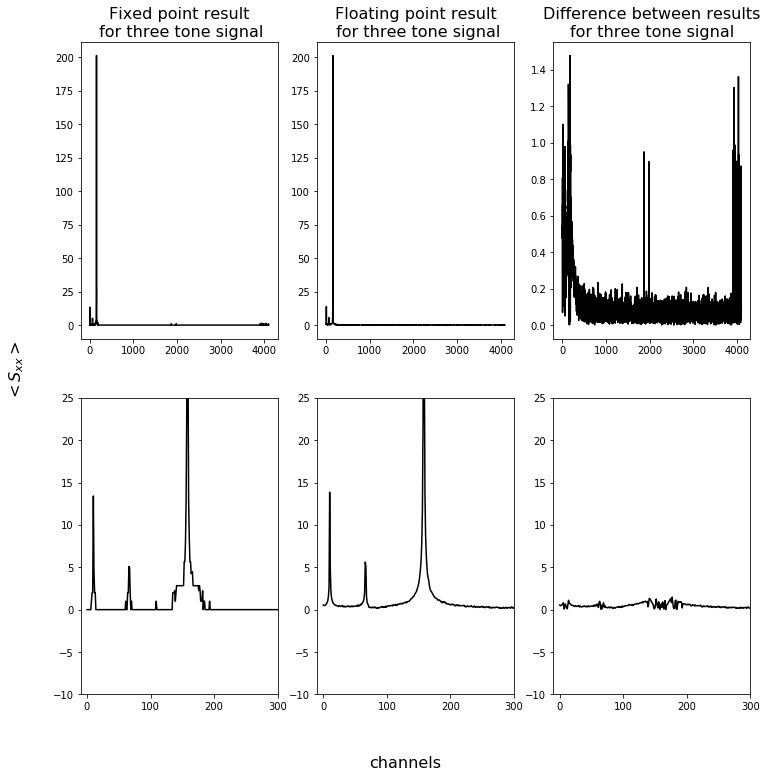

In [221]:
meandiffeven=np.mean(np.abs(np.abs(pfbfxdr.X_k.to_complex()[:2**12,-1]*2**17)-np.abs(pfbflt.X_k)[:2**12,-1]))
meandiffevenzoom=np.mean(np.abs(np.abs(pfbfxdr.X_k.to_complex()[:300,-1]*2**17)-np.abs(pfbflt.X_k)[:300,-1]))
print("MEAN DIFFERENCE OVERALL = ",meandiffeven)
print("ZOOMED MEAN DIFFERENCE = ",meandiffevenzoom)
tworesplotter(np.abs(pfbfxdr.X_k.to_complex()[:2**12,-1]*2**17),np.abs(pfbflt.X_k)[:2**12,-1])

It appears that for the even we get a significantly better error that for the infinite and truncating scheme. The final test is to check a rounding implementation used by SARAO's 1k F-Engine. Namely, round $\pm\infty$ in the FFT and evenly round in the FIR. 

In [222]:
inpfxsig=cfixpoint(9,9,method="ROUND")               #EVENLY ROUND INPUT DATA
inpfxsig.from_complex(input_vector)
pfbfxmx = pfbx(N=2**13,taps=8,bits_in=9,bits_out=17,twidbits=17,shiftreg=shiftreg.copy(),
               w='hamming',firmethod="ROUND",fftmethod="ROUND_INFTY") #INFTY ROUND IN FFT AND EVENLY ROUND IN FIR
pfbfxmx.run(inpfxsig)                 #RUN ON DATA

Below is plotted the results and differences


MEAN DIFFERENCE OVERALL =  1.04952196451003
ZOOMED MEAN DIFFERENCE =  1.6286465903700758


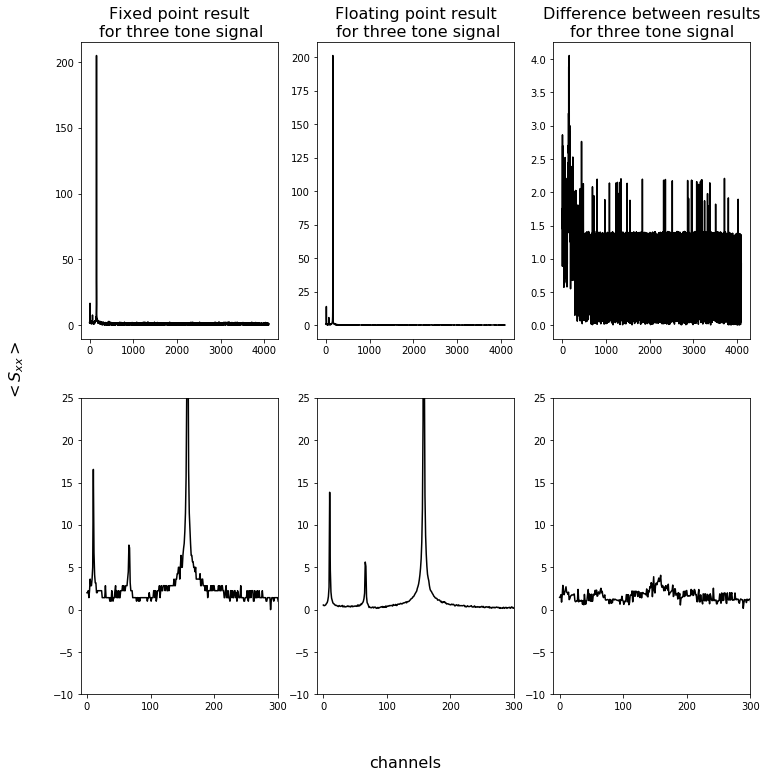

In [223]:
meandiffmix=np.mean(np.abs(np.abs(pfbfxmx.X_k.to_complex()[:2**12,-1]*2**17)-np.abs(pfbflt.X_k)[:2**12,-1]))
meandiffmixzoom=np.mean(np.abs(np.abs(pfbfxmx.X_k.to_complex()[:300,-1]*2**17)-np.abs(pfbflt.X_k)[:300,-1]))
print("MEAN DIFFERENCE OVERALL = ",meandiffmix)
print("ZOOMED MEAN DIFFERENCE = ",meandiffmixzoom)
tworesplotter(np.abs(pfbfxmx.X_k.to_complex()[:2**12,-1]*2**17),np.abs(pfbflt.X_k)[:2**12,-1])

This mixed rounding scheme has produced a result with the same error as the infinite rounding scheme. This is probably due to the fact that the effects of rounding are only felt in the FFT (since we grow the data from 10bits to 18bits in the FIR, we don't quantise (round) that data).

Below, we now look to run the same PFB's, but this time, on an input signal comprising of 2 spikes.

In [225]:
def tworesplotter(res1,res2):
    fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(12, 12))
    ax[0,0].plot(res1,'k')
    ax[0,0].set_title("Fixed point result\n for spike signal",fontsize=16)
    ax[0,1].plot(res2,'k')
    ax[0,1].set_title("Floating point result\n for spike signal",fontsize=16)
    ax[1,0].plot(res1,'k')
    ax[1,0].set_ylim(-5,6)
    ax[1,0].set_xlim(-10,300)
    ax[1,1].plot(res2,'k')
    ax[1,1].set_ylim(-5,6)
    ax[1,1].set_xlim(-10,300)
    ax[0,2].plot(np.abs(res1-res2),'k')
    ax[0,2].set_title("Difference between results\nfor spike signal",fontsize=16)
    ax[1,2].plot(np.abs(res1-res2),'k')
    ax[1,2].set_xlim(-10,300)
    ax[1,2].set_ylim(-5,6)
    fig.text(0.5, 0.04, 'channels', ha='center',fontsize=16)
    fig.text(0.04, 0.5, '$<S_{xx}>$', va='center', rotation='vertical',fontsize=16)
    fig.show()

SNR =  25.59178304681818
dBFS =  -85.4285955172859


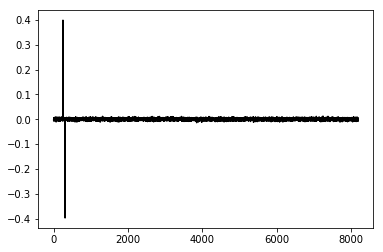

In [250]:
noise = ((np.random.normal(size=N,scale = 0.3)).astype(np.float64)/85)    #SOME NOISE
spikes = np.zeros(N,dtype=np.float64)
slc1 = slice(250,N,2**13)
slc2 = slice(307,N,2**13)
spikes[slc1]=0.4
spikes[slc2]=-0.4
input_vector=noise+spikes                                                   #NOISE WITH SPIKES
plt.plot(input_vector[:2**13],'k')
print("SNR = ", 20*np.log10(np.max(np.abs(spikes[:2**15]))/np.max(np.abs(noise[:2**15]+(0.5/85)))))
print("dBFS = ", 20*np.log10(np.abs(np.mean(input_vector[:2**15]))/(1)))

Again, first we check the truncation instance, but this time with a zero'd shiftregister.

In [251]:
shiftreg=[0,0,0,0,0,0,0,0,0,0,0,0,0]                #ZERO'D SHIFT REGISTER
inpfxsig=cfixpoint(9,9,method="TRUNCATE")           #TRUNCATE INPUT DATA
inpfxsig.from_complex(input_vector)
pfbfxdt = pfbx(N=2**13,taps=8,bits_in=9,bits_out=17,twidbits=17,shiftreg=shiftreg.copy(),
               w='hamming',firmethod="TRUNCATE",fftmethod="TRUNCATE")  #FIXED PFB
pfbfxdt.run(inpfxsig)                              #RUN FIXED PFB ON DATA
pfbflt.run(input_vector)                           #RUN FLOAT PFB ON DATA

Below is again plotted the last PFB results on the first row, zoomed results on the second row and the absolute difference in the third column. Also, at the top is displayed the absolute mean difference for both the full and zoomed results.

MEAN DIFFERENCE OVERALL =  0.10507799344814539
ZOOMED MEAN DIFFERENCE =  0.10668436373906626


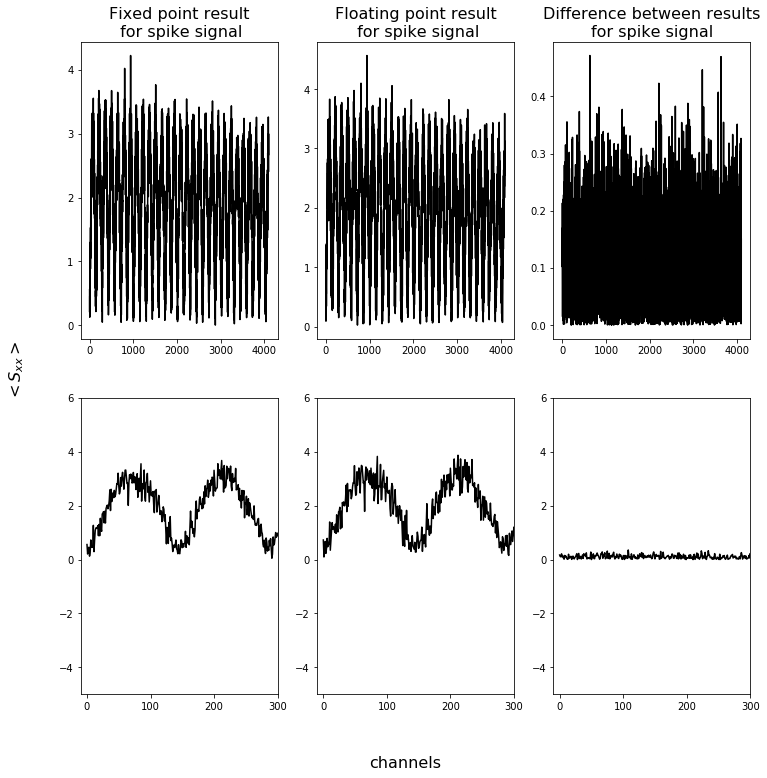

In [253]:
val=(pfbfxdt.X_k.to_complex()[:2**12,-1]*2**4)
val=np.abs(val)
tworesplotter(val,np.abs(pfbflt.X_k)[:2**12,-1])
meandifftrunc=np.mean(np.abs(val-np.abs(pfbflt.X_k)[:2**12,-1]))
meandifftrunczoom=np.mean(np.abs(val[:300]-np.abs(pfbflt.X_k)[:300,-1]))
print("MEAN DIFFERENCE OVERALL = ",meandifftrunc)
print("ZOOMED MEAN DIFFERENCE = ",meandifftrunczoom)

Now testing the infinite rounding scheme we have

In [254]:
inpfxsig=cfixpoint(9,9,method="ROUND_INFTY")    #INPUT DATA WITH INFTY ROUNDING SCHEME
inpfxsig.from_complex(input_vector)
pfbfxdru = pfbx(N=2**13,taps=8,bits_in=9,bits_out=17,twidbits=17,shiftreg=shiftreg.copy(),
                w='hamming',firmethod="ROUND_INFTY",fftmethod="ROUND_INFTY")
pfbfxdru.run(inpfxsig)                          #RUN FXT PT PFB ON DATA

Below is displayed the results

MEAN DIFFERENCE OVERALL =  0.06101471687981709
ZOOMED MEAN DIFFERENCE =  0.0604075885729601


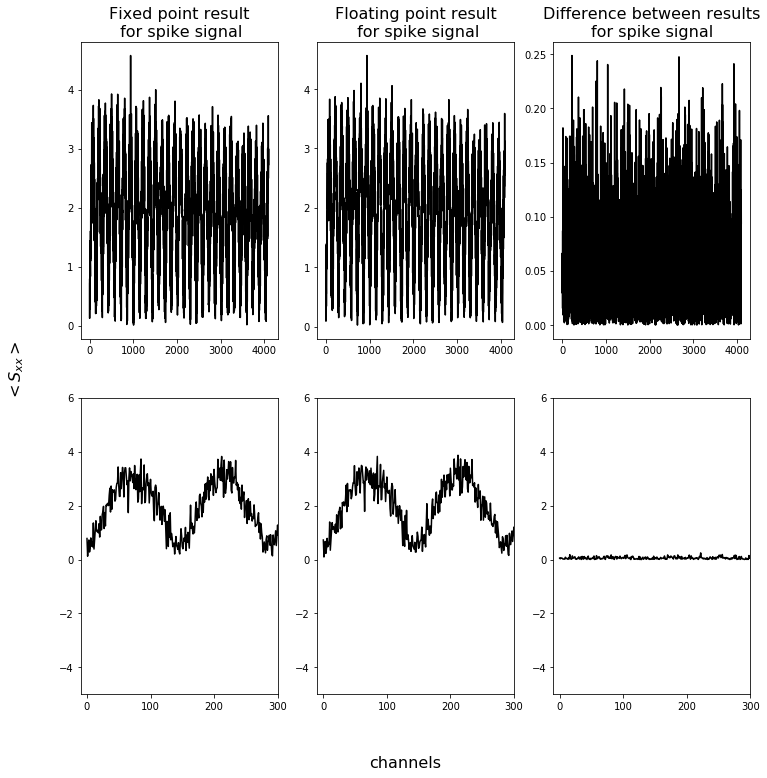

In [255]:
meandiffinfinite=np.mean(np.abs(np.abs(pfbfxdru.X_k.to_complex()[:2**12,-1]*2**4)-np.abs(pfbflt.X_k)[:2**12,-1]))
meandiffinfinitezoom=np.mean(np.abs(np.abs(pfbfxdru.X_k.to_complex()[:300,-1]*2**4)-np.abs(pfbflt.X_k)[:300,-1]))
print("MEAN DIFFERENCE OVERALL = ",meandiffinfinite)
print("ZOOMED MEAN DIFFERENCE = ",meandiffinfinitezoom)
tworesplotter(np.abs(pfbfxdru.X_k.to_complex()[:2**12,-1]*2**4),np.abs(pfbflt.X_k)[:2**12,-1])

Now testing the even rounding scheme

In [256]:
inpfxsig=cfixpoint(9,9,method="ROUND")              #INPUT DATA WITH EVEN ROUNDING
inpfxsig.from_complex(input_vector)
pfbfxdr = pfbx(N=2**13,taps=8,bits_in=9,bits_out=17,twidbits=17,shiftreg=shiftreg.copy(),
               w='hamming',firmethod="ROUND",fftmethod="ROUND") #THE FXT PT PFB
pfbfxdr.run(inpfxsig)           #RUN IT ON DATA

Below we have the final results.

MEAN DIFFERENCE OVERALL =  0.06101471687981709
ZOOMED MEAN DIFFERENCE =  0.0604075885729601


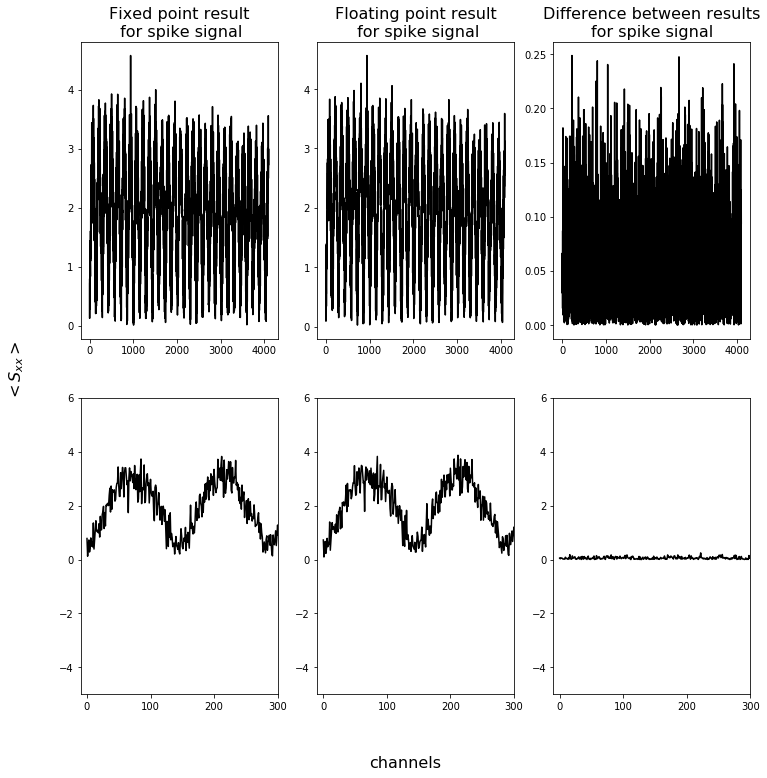

In [257]:
meandiffeven=np.mean(np.abs(np.abs(pfbfxdr.X_k.to_complex()[:2**12,-1]*2**4)-np.abs(pfbflt.X_k)[:2**12,-1]))
meandiffevenzoom=np.mean(np.abs(np.abs(pfbfxdr.X_k.to_complex()[:300,-1]*2**4)-np.abs(pfbflt.X_k)[:300,-1]))
print("MEAN DIFFERENCE OVERALL = ",meandiffeven)
print("ZOOMED MEAN DIFFERENCE = ",meandiffevenzoom)
tworesplotter(np.abs(pfbfxdr.X_k.to_complex()[:2**12,-1]*2**4),np.abs(pfbflt.X_k)[:2**12,-1])

Since, as was made apparent by the before text, the mixed PFB will only display the results of the FFT rounding scheme. So it is ignored for this test. 

With no shifting, the infinite rounding and even rounding schemes match - while, the truncation scheme fares worse than them.